In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import tqdm
import os
import mcbe
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras.datasets
from skimage.color import rgb2gray

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [14]:
#transform to grayscale
#X_train = rgb2gray(X_train)
#X_test = rgb2gray(X_test)

In [15]:
X_train = np.array([X_train[i].flatten() for i in range(X_train.shape[0])])
X_test = np.array([X_test[i].flatten() for i in range(X_test.shape[0])])

In [16]:
#normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
X_train.shape

(50000, 3072)

In [18]:
# size of the layers
#l1 = 256
#l2 = 128

In [19]:
'''class Model(nn.Module):
    def __init__(self, input_dim, l1):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, l1)
        self.layer2 = nn.Linear(l1, l2)
        self.layer3 = nn.Linear(l2, 10)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x'''

'class Model(nn.Module):\n    def __init__(self, input_dim, l1):\n        super(Model, self).__init__()\n        self.layer1 = nn.Linear(input_dim, l1)\n        self.layer2 = nn.Linear(l1, l2)\n        self.layer3 = nn.Linear(l2, 10)\n        \n    def forward(self, x):\n        x = F.relu(self.layer1(x))\n        x = F.relu(self.layer2(x))\n        x = F.softmax(self.layer3(x), dim=1)\n        return x'

In [20]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
#model     = Model(X_train.shape[1],l1)
model     = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [23]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [24]:
#initialize lists

EPOCHS  = 50

weights = []
weights_norm = []
norms = []
biases = np.zeros([EPOCHS + 1,l1])

w1 = model.layer1.weight
b1 = model.layer1.bias
m1 = w1.shape[0]
n1 = w1.shape[1]
norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
w1_norm = torch.div(w1,norm)
w1_norm[w1_norm == np.inf] = 0

    
weights.append(w1.detach().numpy())
weights_norm.append(w1_norm.detach().numpy())
norms.append(norm.detach().numpy())
biases[0,:] = b1.detach().numpy()

#epoch counter
k = 1


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Loss {loss.item()}, Accuracy {correct.mean()}")
    
    
    
    w1 = model.layer1.weight
    b1 = model.layer1.bias
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0
    
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[k,:] = b1.detach().numpy()
    
    k = k+1
   
accuracy_list

NameError: name 'l1' is not defined

Text(0, 0.5, 'Accuracy')

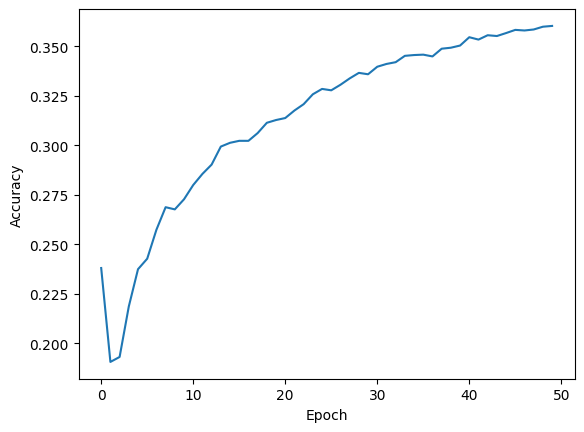

In [ ]:
plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')